# Can you help reduce employee turnover?

## 📖 Background
You work for the human resource department of a large corporation. The Board is worried about the relatively high turnover, and your team must look into ways to reduce the number of employees leaving the company.

The team needs to understand better the situation, which employees are more likely to leave, and why. Once it is clear what variables impact employee churn, you can present your findings along with your ideas on how to attack the problem.

## 💾 The data
The department has assembled data on almost 10,000 employees. The team used information from exit interviews, performance reviews, and employee records.

- "department" - the department the employee belongs to.
- "promoted" - 1 if the employee was promoted in the previous 24 months, 0 otherwise.
- "review" - the composite score the employee received in their last evaluation.
- "projects" - how many projects the employee is involved in.
- "salary" - for confidentiality reasons, salary comes in three tiers: low, medium, high.
- "tenure" - how many years the employee has been at the company.
- "satisfaction" - a measure of employee satisfaction from surveys.
- "avg_hrs_month" - the average hours the employee worked in a month.
- "left" - "yes" if the employee ended up leaving, "no" otherwise.

## Create a report that covers the following:

1. Which department has the highest employee turnover? Which one has the lowest?
2. Investigate which variables seem to be better predictors of employee departure.
3. What recommendations would you make regarding ways to reduce employee turnover?

## Report content:

-
1. Preliminary remarks and data exploration.
2. Feature design and exploration.
3. Modelling and feature selection.
4. Recommendations to reduce employee turnover.

In [0]:
%run "../../Includes/Classroom-Setup"

Mounting course-specific datasets to /mnt/training ... Datasets are already mounted to /mnt/training from wasbs://training@dbtrainukwest.blob.core.windows.net/

Out[2]: DataFrame[]

res1: Boolean = false

res2: Boolean = false

res3: Boolean = false

In [0]:
%pip install imbalanced-learn

Python interpreter will be restarted.
Collecting imbalanced-learn
 Downloading imbalanced_learn-0.9.0-py3-none-any.whl (199 kB)
Requirement already satisfied: threadpoolctl>=2.0.0 in /databricks/python3/lib/python3.8/site-packages (from imbalanced-learn) (2.1.0)
Requirement already satisfied: numpy>=1.14.6 in /databricks/python3/lib/python3.8/site-packages (from imbalanced-learn) (1.19.2)
Requirement already satisfied: joblib>=0.11 in /databricks/python3/lib/python3.8/site-packages (from imbalanced-learn) (1.0.1)
Collecting scikit-learn>=1.0.1
 Downloading scikit_learn-1.0.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Requirement already satisfied: scipy>=1.1.0 in /databricks/python3/lib/python3.8/site-packages (from imbalanced-learn) (1.6.2)
Installing collected packages: scikit-learn, imbalanced-learn
 Attempting uninstall: scikit-learn
 Found existing installation: scikit-learn 0.24.1
 Not uninstalling scikit-learn at /databricks/python3/lib/python3.8/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-1b4983d0-c337-4a54-b6ed-ede8c991a28b
 Can't uninstall 'scikit-learn'. No files were found to uninstall.
Successfully installed imbalanced-learn-0.9.0 scikit-learn-1.0.2
WARNING: You are using pip version 21.0.1; however, version 21.3.1 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-1b4983d0-c337-4a54-b6ed-ede8c991a28b/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score

In [0]:
%sql
SELECT * FROM adsda.employee_churn_data LIMIT 10

department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
operations,0,0.5775686596355698,3,low,5.0,0.6267589740293295,0,180.8660696668475,no
operations,0,0.7518996607137884,3,medium,6.0,0.4436789547574034,0,182.7081489616225,no
support,0,0.7225484486077993,3,medium,6.0,0.4468232240377964,0,184.4160840365652,no
logistics,0,0.6751583086657402,4,high,8.0,0.4401387461171622,0,188.7075447757313,no
sales,0,0.676203174778892,3,high,5.0,0.5776074456916579,1,179.82108327312108,no
IT,0,0.6832063469509659,2,medium,5.0,0.5652518631559001,1,178.8418791506508,no
admin,0,0.6201580151095236,4,high,5.0,0.6869511701465508,0,181.14295615536423,no
support,0,0.4995672619674808,4,medium,7.0,0.720451118181815,1,184.97753752486025,no
sales,0,0.652817953302604,4,low,6.0,0.6786959372102828,0,183.6557898051497,no
sales,0,0.642030504394421,3,medium,6.0,0.6233650093739659,0,181.8509998905145,no


### 1. Preliminary remarks and data exploration.

Prior to technical analysis, tt is a good idea to gain the 'domain knowledge' e.g. by speaking the HR deparment about what they consider to be the main causes of employee departures. This could aid in selecting important  features.

In [0]:
# convert the table to a dataframe
df = spark.table("adsda.employee_churn_data").toPandas()

In [0]:
# Understand your variables
variables = pd.DataFrame(columns=['Variable','Number of unique values','Number of nulls','Values'])

for i, var in enumerate(df.columns):
    variables.loc[i] = [var, df[var].nunique(),df[var].isnull().sum(), df[var].unique().tolist()]
variables

Out[5]:

,Variable,Number of unique values,Number of nulls,Values
0,department,10,0,"[operations, support, logistics, sales, IT, ad..."
1,promoted,2,0,"[0, 1]"
2,review,9540,0,"[0.5775686596355698, 0.7518996607137884, 0.722..."
3,projects,4,0,"[3, 4, 2, 5]"
4,salary,3,0,"[low, medium, high]"
5,tenure,11,0,"[5.0, 6.0, 8.0, 7.0, 4.0, 3.0, 2.0, 9.0, 10.0,..."
6,satisfaction,9540,0,"[0.6267589740293295, 0.4436789547574034, 0.446..."
7,bonus,2,0,"[0, 1]"
8,avg_hrs_month,9540,0,"[180.8660696668475, 182.7081489616225, 184.416..."
9,left,2,0,"[no, yes]"


In [0]:
#display(spark.sql("SELECT * FROM adsda.employee_churn_data").summary())
df.describe(include='all')

Out[6]:

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
count,9540,9540.000000,9540.000000,9540.000000,9540,9540.000000,9540.000000,9540.000000,9540.000000,9540
unique,10,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,2
top,sales,NaN,NaN,NaN,medium,NaN,NaN,NaN,NaN,no
freq,1883,NaN,NaN,NaN,6611,NaN,NaN,NaN,NaN,6756
mean,NaN,0.030294,0.651826,3.274843,NaN,6.556184,0.504645,0.212055,184.661571,NaN
std,NaN,0.171403,0.085307,0.579136,NaN,1.415432,0.158555,0.408785,4.144831,NaN
min,NaN,0.000000,0.310000,2.000000,NaN,2.000000,0.000000,0.000000,171.374060,NaN
25%,NaN,0.000000,0.592884,3.000000,NaN,5.000000,0.386801,0.000000,181.472085,NaN
50%,NaN,0.000000,0.647456,3.000000,NaN,7.000000,0.500786,0.000000,184.628796,NaN
75%,NaN,0.000000,0.708379,4.000000,NaN,8.000000,0.622607,0.000000,187.728708,NaN


In [0]:
df['left'].value_counts()   # it is an inbalanced dataset with 30% of yes and 70% of no.

Out[7]: no 6756
yes 2784
Name: left, dtype: int64

In [0]:
%sql
SELECT * FROM adsda.employee_churn_data

department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
operations,0,0.5775686596355698,3,low,5.0,0.6267589740293295,0,180.8660696668475,no
operations,0,0.7518996607137884,3,medium,6.0,0.4436789547574034,0,182.7081489616225,no
support,0,0.7225484486077993,3,medium,6.0,0.4468232240377964,0,184.4160840365652,no
logistics,0,0.6751583086657402,4,high,8.0,0.4401387461171622,0,188.7075447757313,no
sales,0,0.676203174778892,3,high,5.0,0.5776074456916579,1,179.82108327312108,no
IT,0,0.6832063469509659,2,medium,5.0,0.5652518631559001,1,178.8418791506508,no
admin,0,0.6201580151095236,4,high,5.0,0.6869511701465508,0,181.14295615536423,no
support,0,0.4995672619674808,4,medium,7.0,0.720451118181815,1,184.97753752486025,no
sales,0,0.652817953302604,4,low,6.0,0.6786959372102828,0,183.6557898051497,no
sales,0,0.642030504394421,3,medium,6.0,0.6233650093739659,0,181.8509998905145,no


In [0]:
%sql
SELECT * FROM adsda.employee_churn_data

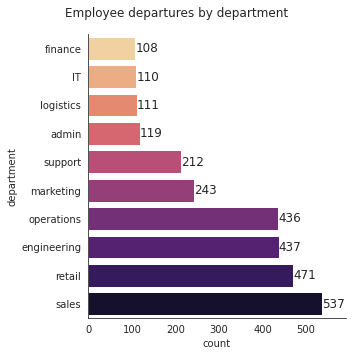

In [0]:
sns.set_style('white')
filter = df['left'] == 'yes'
g = sns.catplot(data=df[filter], kind='count', y='department', palette='magma_r',
            order=df[filter]['department'].value_counts(ascending=True).index)
g.fig.suptitle('Employee departures by department')
g.fig.subplots_adjust(top=0.9)

#abs_values = df[filter]['department'].value_counts(ascending=True)
#g.bar_label(container=g.containers[0], labels=abs_values)
for ax in g.axes.flat:
    ax.bar_label(ax.containers[0], fontsize=12)
    ax.margins(x=0.1)
    
plt.tight_layout()
plt.show()

#####As we can see from the bar chart, the highest employee turnover is at the sales department followed by retail, engineering and operations. On the other end of the scale are finance, IT, logistics and admin with the lowest employee turnover.

### 2. Feature design and exploration.

The dataset has mixed data with both numerical and categorical values. Some of the features, bonus and promoted, are binomial, while department and salary are ordinal. There are no missing vales and requires scaling (the larger values for average hours per month). The scatterplots show that two pairs of features, average hours per month and tenure, and review and satisfaction, are strongly correlated with each other. The numeric variables  are normally distributioned

In [0]:
cat_cols = ['department','promoted','salary','bonus', 'left']
df[cat_cols] = df[cat_cols].astype('category')

In [0]:
# One-hot encoding of the categorical features  
df = pd.get_dummies(df, columns=['department'])
df.columns

Out[10]: Index(['promoted', 'review', 'projects', 'salary', 'tenure', 'satisfaction',
 'bonus', 'avg_hrs_month', 'left', 'department_IT', 'department_admin',
 'department_engineering', 'department_finance', 'department_logistics',
 'department_marketing', 'department_operations', 'department_retail',
 'department_sales', 'department_support'],
 dtype='object')

In [0]:
df.columns = df.columns.str.replace('department_','')

df1 = df.loc[:,df.columns!='left']
df2 = df.loc[:,df.columns=='left']
df = pd.concat([df1, df2], 1)
df.head()

Out[11]:

,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,IT,admin,engineering,finance,logistics,marketing,operations,retail,sales,support,left
0,0,0.577569,3,low,5.0,0.626759,0,180.866070,0,0,0,0,0,0,1,0,0,0,no
1,0,0.751900,3,medium,6.0,0.443679,0,182.708149,0,0,0,0,0,0,1,0,0,0,no
2,0,0.722548,3,medium,6.0,0.446823,0,184.416084,0,0,0,0,0,0,0,0,0,1,no
3,0,0.675158,4,high,8.0,0.440139,0,188.707545,0,0,0,0,1,0,0,0,0,0,no
4,0,0.676203,3,high,5.0,0.577607,1,179.821083,0,0,0,0,0,0,0,0,1,0,no


In [0]:
# Ordinal encode of salary and left 
oe = OrdinalEncoder()

df[["salary","left"]] = oe.fit_transform(df[["salary", "left"]])
df["salary"] = df["salary"].replace(0,3)
df

Out[12]:

,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,IT,admin,engineering,finance,logistics,marketing,operations,retail,sales,support,left
0,0,0.577569,3,1.0,5.0,0.626759,0,180.866070,0,0,0,0,0,0,1,0,0,0,0.0
1,0,0.751900,3,2.0,6.0,0.443679,0,182.708149,0,0,0,0,0,0,1,0,0,0,0.0
2,0,0.722548,3,2.0,6.0,0.446823,0,184.416084,0,0,0,0,0,0,0,0,0,1,0.0
3,0,0.675158,4,3.0,8.0,0.440139,0,188.707545,0,0,0,0,1,0,0,0,0,0,0.0
4,0,0.676203,3,3.0,5.0,0.577607,1,179.821083,0,0,0,0,0,0,0,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9535,0,0.610988,4,2.0,8.0,0.543641,0,188.155738,0,0,0,0,0,0,1,0,0,0,1.0
9536,0,0.746887,3,2.0,8.0,0.549048,0,188.176164,0,0,0,0,1,0,0,0,0,0,1.0
9537,0,0.557980,3,1.0,7.0,0.705425,0,186.531008,0,0,0,0,0,0,1,0,0,0,1.0
9538,0,0.584446,4,2.0,8.0,0.607287,1,187.641370,1,0,0,0,0,0,0,0,0,0,1.0


In [0]:
df_dept = df.iloc[:, -10:]
df_dept.head(2)

Out[13]:

,admin,engineering,finance,logistics,marketing,operations,retail,sales,support,left
0,0,0,0,0,0,1,0,0,0,0.0
1,0,0,0,0,0,1,0,0,0,0.0


In [0]:
# select the continious and ordinal columns for Spearmens' 
spearmans_cols = ['review','satisfaction', 'avg_hrs_month', 'tenure', 'projects','salary', 'left']
df_sp = df[spearmans_cols]
df_sp

sc = StandardScaler()
df_scaled = pd.DataFrame(sc.fit_transform(df_sp), index=df_sp.index, columns=df_sp.columns)
df_scaled

Out[14]:

,review,satisfaction,avg_hrs_month,tenure,projects,salary,left
0,-0.870524,0.770211,-0.915767,-1.099499,-0.474599,-1.837249,-0.641933
1,1.173161,-0.384527,-0.471316,-0.392964,-0.474599,-0.031608,-0.641933
2,0.829076,-0.364695,-0.059230,-0.392964,-0.474599,-0.031608,-0.641933
3,0.273521,-0.406856,0.976200,1.020106,1.252203,1.774033,-0.641933
4,0.285770,0.460198,-1.167898,-1.099499,-0.474599,1.774033,-0.641933
...,...,...,...,...,...,...,...
9535,-0.478744,0.245959,0.843062,1.020106,1.252203,-0.031608,1.557795
9536,1.114402,0.280068,0.847991,1.020106,-0.474599,-0.031608,1.557795
9537,-1.100166,1.266378,0.451052,0.313571,-0.474599,-1.837249,1.557795
9538,-0.789903,0.647395,0.718957,1.020106,1.252203,-0.031608,1.557795


Lets investigate the relationships between the features.

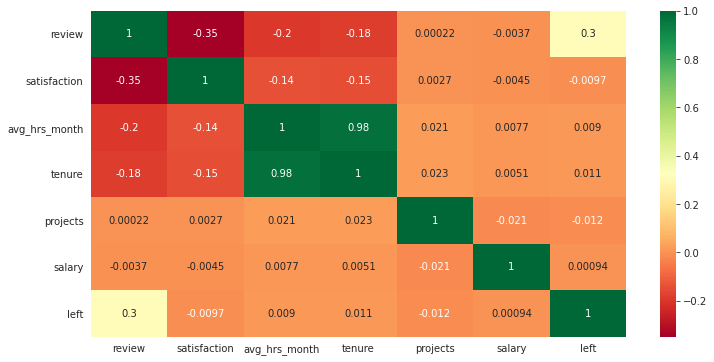

In [0]:
corrmat = df_scaled.corr(method ='spearman')
top_corr_features = corrmat.index
plt.figure(figsize=(12,6))
#plot heat map
g=sns.heatmap(df_scaled[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Spearman's correlation is good for ordinal data. The correlation matrix shows that satisfaction from the job and the number of projects an employee's involved indicate a negative relationship with employee departure, i.e. a satisfied employee busy with many projects is more likely to stay. However, high review scores seem to significantly contribute to the number of depatures with the corr coef = 0.3. Meanwhile, satisfaction is negatively correlated with performance reviews, suggesting that higher scores in reviews area associated with lower levels of satisfaction. Average hours of work per month are almost perfectly postively correlated, suggesting that they're interchangble as features.

In [0]:
X_features = df.drop('left', axis=1)
y_target = df[['left']]

sc = StandardScaler()
X_features_scaled = sc.fit_transform(X_features)
X_features_scaled

df_scaled = pd.DataFrame(sc.fit_transform(df), index=df.index, columns=df.columns)
df_scaled

Out[16]:

,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,IT,admin,engineering,finance,logistics,marketing,operations,retail,sales,support,left
0,-0.176748,-0.870524,-0.474599,-1.837249,-1.099499,0.770211,-0.518771,-0.915767,-0.196883,-0.215399,-0.434664,-0.209743,-0.198030,-0.302957,2.295227,-0.438918,-0.495902,-0.288921,-0.641933
1,-0.176748,1.173161,-0.474599,-0.031608,-0.392964,-0.384527,-0.518771,-0.471316,-0.196883,-0.215399,-0.434664,-0.209743,-0.198030,-0.302957,2.295227,-0.438918,-0.495902,-0.288921,-0.641933
2,-0.176748,0.829076,-0.474599,-0.031608,-0.392964,-0.364695,-0.518771,-0.059230,-0.196883,-0.215399,-0.434664,-0.209743,-0.198030,-0.302957,-0.435687,-0.438918,-0.495902,3.461155,-0.641933
3,-0.176748,0.273521,1.252203,1.774033,1.020106,-0.406856,-0.518771,0.976200,-0.196883,-0.215399,-0.434664,-0.209743,5.049752,-0.302957,-0.435687,-0.438918,-0.495902,-0.288921,-0.641933
4,-0.176748,0.285770,-0.474599,1.774033,-1.099499,0.460198,1.927633,-1.167898,-0.196883,-0.215399,-0.434664,-0.209743,-0.198030,-0.302957,-0.435687,-0.438918,2.016528,-0.288921,-0.641933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9535,-0.176748,-0.478744,1.252203,-0.031608,1.020106,0.245959,-0.518771,0.843062,-0.196883,-0.215399,-0.434664,-0.209743,-0.198030,-0.302957,2.295227,-0.438918,-0.495902,-0.288921,1.557795
9536,-0.176748,1.114402,-0.474599,-0.031608,1.020106,0.280068,-0.518771,0.847991,-0.196883,-0.215399,-0.434664,-0.209743,5.049752,-0.302957,-0.435687,-0.438918,-0.495902,-0.288921,1.557795
9537,-0.176748,-1.100166,-0.474599,-1.837249,0.313571,1.266378,-0.518771,0.451052,-0.196883,-0.215399,-0.434664,-0.209743,-0.198030,-0.302957,2.295227,-0.438918,-0.495902,-0.288921,1.557795
9538,-0.176748,-0.789903,1.252203,-0.031608,1.020106,0.647395,1.927633,0.718957,5.079149,-0.215399,-0.434664,-0.209743,-0.198030,-0.302957,-0.435687,-0.438918,-0.495902,-0.288921,1.557795


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_features_scaled, y_target, test_size=0.15, random_state=32)

### 3. Modelling and feature selection.

Distance based methods such as KNN,  Decision trees and their ensemble, Random Forest are better at handing mixed data. Tree-based models are good at capturing non-linear relationships between the categorical features and the target, and they tend to handle feature collinearity better.
I will be using two methods for feature selection described here, <https://scikit-learn.org/stable/modules/feature_selection.html>
    - Univariate feature selection with the mutual information(M()) classification function,
    - Tree-based feature importances with the SelectFromModel meta-transformer
  
MI measures the degree of relatedness between data sets, or in other words, it  quantifies the extent to which a feature (e.g. the review score) determines the employee's departure.

In [0]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

fs = SelectKBest(score_func=mutual_info_classif, k=5).fit(X_features, y_target)
fs

/local_disk0/.ephemeral_nfs/envs/pythonEnv-1b4983d0-c337-4a54-b6ed-ede8c991a28b/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 y = column_or_1d(y, warn=True)
Out[18]: SelectKBest(k=5, score_func=<function mutual_info_classif at 0x7fb4da3fab80>)

In [0]:
#projects and tenure can be ordinarily encoded. Num_cols include continious  data while cat_cols include categorical/binomial.

num_cols = ['review','satisfaction', 'avg_hrs_month', 'tenure', 'projects']
cat_cols = ['salary','department','bonus','promoted','left']

In [0]:
print(fs.scores_)

[0. 0.06208892 0.00469279 0. 0.04147919 0.00082961
 0. 0.05998497 0.00219096 0.00580968 0. 0.
 0. 0. 0.00279045 0. 0. 0.00299287]

In [0]:
f_importance = fs.scores_

In [0]:
idx = np.argsort(f_importance)
idx

Out[22]: array([ 0, 15, 13, 3, 12, 6, 11, 16, 10, 5, 8, 14, 17, 2, 9, 4, 7,
 1])

In [0]:
cols = X_features.columns.values.tolist()

arr_f = np.array(cols)[idx]
arr_f

Out[23]: array(['promoted', 'retail', 'marketing', 'salary', 'logistics', 'bonus',
 'finance', 'sales', 'engineering', 'satisfaction', 'IT',
 'operations', 'support', 'projects', 'admin', 'tenure',
 'avg_hrs_month', 'review'], dtype='<U13')

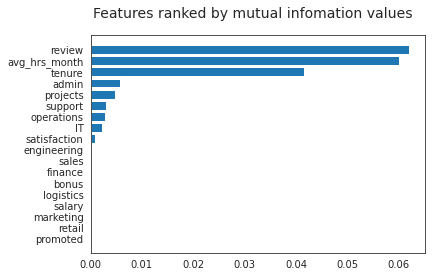

In [0]:
plt.barh(arr_f, f_importance[idx])
plt.suptitle('Features ranked by mutual infomation values', fontsize=14)
plt.show()

#####From the above bar chart, Review, Average hours per month and tenure are the three top features influencing  employee departure.

I will use two tree-based models, Random ForestClassifier() and GradientBoostingClassifier() for feature selection. 

I will try to optimize my models for the F1 metric, which takes an account both precision and recall for the cases of employee departures. The recall metric focuses on  what percentage of all cases of employee departures  the model has predicted correctly  while precision measures what percentage of all predicted employee departures are true employee departures.
In the below analysis, the number of the correct predictions for employee departures (aka true positives), is shown in the bottom right corner of the confusion matrix.
by using the RandomForest and AdaBoost classifiers

In [0]:
X = df[['promoted', 'review', 'projects', 'salary', 'tenure', 'satisfaction',
       'bonus', 'avg_hrs_month']]
                          
y = df['left']

###### After experimenting with different under- and over-sampling techniques to balance my dataset, I will employ the oversampling strategy to the minority class to be the same size as the majority class. It achieves the highest F1_score =0.93 for the employee departures in the dataset.

In [0]:
from imblearn.over_sampling import RandomOverSampler
oversample_1 = RandomOverSampler(sampling_strategy='minority')

X_over, y_over = oversample_1.fit_resample(X, y)
print(y_over.value_counts())

0.0 6756
1.0 6756
Name: left, dtype: int64

[[1534 208]
 [ 66 1570]]
/local_disk0/.ephemeral_nfs/envs/pythonEnv-1b4983d0-c337-4a54-b6ed-ede8c991a28b/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
 warnings.warn(msg, category=FutureWarning)

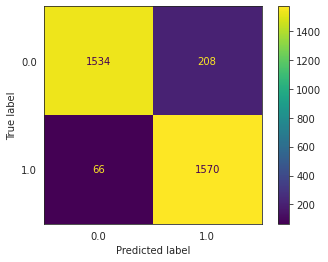

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over)

rf = RandomForestClassifier(random_state=8)

rf1 =rf.fit(X_train, y_train)

pred1 = rf1.predict(X_test)
print(confusion_matrix(y_test, rf.predict(X_test)))

plot_confusion_matrix(rf, X_test, y_test)  
plt.show()

In [0]:
print(classification_report(y_test, pred1))  #0.91, 0.97

precision recall f1-score support

 0.0 0.96 0.88 0.92 1742
 1.0 0.88 0.96 0.92 1636

 accuracy 0.92 3378
 macro avg 0.92 0.92 0.92 3378
weighted avg 0.92 0.92 0.92 3378

In [0]:
#%pip install imbalanced-learn

### Random forest classification

In [0]:
# Generate the validation and test subsets using the balanced data.
over_df = X_over.copy()
over_df.insert(8,"left", y_over)
over_df

Out[30]:

,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,0,0.577569,3,1.0,5.0,0.626759,0,180.866070,0.0
1,0,0.751900,3,2.0,6.0,0.443679,0,182.708149,0.0
2,0,0.722548,3,2.0,6.0,0.446823,0,184.416084,0.0
3,0,0.675158,4,3.0,8.0,0.440139,0,188.707545,0.0
4,0,0.676203,3,3.0,5.0,0.577607,1,179.821083,0.0
...,...,...,...,...,...,...,...,...,...
13507,0,0.588648,3,3.0,7.0,0.831328,0,185.584152,1.0
13508,0,0.638359,3,2.0,7.0,0.649101,0,187.434955,1.0
13509,0,0.742408,4,2.0,8.0,0.651910,0,187.987767,1.0
13510,0,0.699004,3,3.0,8.0,0.288292,0,187.601648,1.0


In [0]:
cross_val_df, test_df = train_test_split(over_df, train_size=0.80, test_size=0.20, random_state=32)

In [0]:
rfc = RandomForestClassifier(random_state=32)


In [0]:
parameter_grid = {
  'max_depth':[30, 40, 50, 70,120], 
  'n_estimators':[ 70, 80, 100, 120, 130, 150]
}

In [0]:
grid_search1 = GridSearchCV(estimator=rfc, cv=5, param_grid=parameter_grid, scoring='f1')

In [0]:
grid_search1.fit(cross_val_df.drop("left", axis=1), cross_val_df["left"])

Out[35]: GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=32),
 param_grid={'max_depth': [30, 40, 50, 70, 120],
 'n_estimators': [70, 80, 100, 120, 130, 150]},
 scoring='f1')

In [0]:
grid_search1.best_params_

Out[36]: {'max_depth': 30, 'n_estimators': 150}

In [0]:
grid_search1.best_score_

Out[37]: 0.918469701011397

In [0]:
f1_score(
  test_df["left"], 
  grid_search1.predict(test_df.drop("left", axis=1))
)

Out[38]: 0.9333333333333333

In [0]:
rfc = RandomForestClassifier( n_estimators = 150, max_depth=30, random_state = 32).fit(cross_val_df.drop("left", axis=1), cross_val_df["left"])

In [0]:
rfc.feature_importances_

Out[40]: array([0.00372813, 0.2869656 , 0.01965372, 0.01792896, 0.09706108,
 0.27943763, 0.00983261, 0.28539227])

In [0]:
lst = cross_val_df.drop("left", axis=1).columns.values.tolist()
feature_names = [f"{i}" for i in lst]

std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

importances = rfc.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)

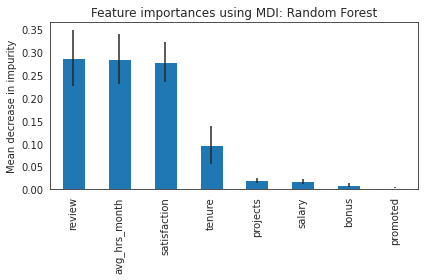

In [0]:
fig, ax = plt.subplots()
forest_importances.sort_values(ascending=False).plot.bar(yerr = -np.sort(-std), ax=ax)
ax.set_title("Feature importances using MDI: Random Forest")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#####The three most important features are average hours per month, review and satisfaction. We should note that Tenure and  average hours can be interchangeable.

###GradientBoostingClassifier()

In [0]:
grad_boost = GradientBoostingClassifier()

In [0]:
parameter_grid = {   
    'max_depth':[8,10,12],
    'n_estimators':[150, 180, 200],
    'learning_rate':[0.01, 0.9, 1, 1.1]
}

In [0]:
grid_search2 = GridSearchCV(estimator = grad_boost,  cv = 5, param_grid = parameter_grid, scoring="f1").fit(cross_val_df.drop("left", axis=1), cross_val_df["left"])


In [0]:
grid_search2.best_params_

Out[49]: {'learning_rate': 0.9, 'max_depth': 12, 'n_estimators': 200}

In [0]:
f1_score(
  test_df["left"], 
  grid_search2.predict(test_df.drop("left", axis=1))
)

Out[50]: 0.9333816075307748

In [0]:
gbc = GradientBoostingClassifier(max_depth= 12, n_estimators = 200, learning_rate= 0.9, random_state = 32).fit(cross_val_df.drop("left", axis=1), cross_val_df["left"])

In [0]:
gbc.feature_importances_

Out[52]: array([0.00280415, 0.27708424, 0.01346519, 0.01748124, 0.00343219,
 0.30202206, 0.01034422, 0.37336671])

In [0]:
importances = gbc.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)

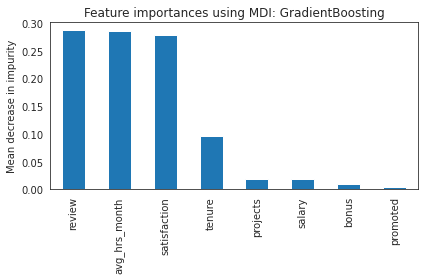

In [0]:
fig, ax = plt.subplots()
forest_importances.sort_values(ascending=False).plot.bar( ax=ax)
ax.set_title("Feature importances using MDI: GradientBoosting")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#####The top three most important features are review, average hours per month and satisfaction.

###  4. Recommendations to reduce the employee turnover.

#####Using several modelling methods, we noted that reviews, average hours per month, tenure and job satisfaction are the most important variables to influence employee departure. While an employee's longer average hours and the duration of stay with the company are associated more with employee retainment, an employee's high review scores are a strong indicator of employee departure. Although this may seem  counterintuitive at first, one of the aspects of a performance review is that an employee's targets get increased putting more pressure on an employee to meet their goals. Indeed,  we can observe that employee satisfaction is negatively correlated with performance reviews, and employee turnover is the highest within the sales and retail departments. 

#####The management need to pay closer attention to the four departments with the highest employee turnover (sales, retail, engineering and operations). If the data for the satisfaction scores is derived exclusively from exit surveys, it can be a leaked variable and not useful for the current analysis. However, if not, looking for more ways to boost employee satisfaction is recommended as this is beneficial for employee retainment.